<a href="https://colab.research.google.com/github/GeorgePearse/data-centric-ai/blob/main/DeepDataValuation_(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Uses pip3 to install necessary package (lightgbm)
!pip3 install lightgbm
!pip3 install git-python
!pip install 'h5py==2.10.0' --force-reinstall

# Resets the IPython kernel to import the installed package.
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)  

  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached numpy-1.21.4-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.4
    Uninstalling numpy-1.21.4:
      Successfully uninstalled numpy-1.21.4
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lucid 0.3.10 requires umap-learn, which is not installed.
tensorflow 1.15.2 requires gast==0.2.2, but you have gast 0.4.0 which is incompatible.
lucid 0.3.10 requir

{'restart': True, 'status': 'ok'}

In [ ]:
%tensorflow_version 1.14.0

In [ ]:
import os
from git import Repo

# Current working directory
repo_dir = os.getcwd() + '/repo'

if not os.path.exists(repo_dir):
    os.makedirs(repo_dir)

# Clones github repository
if not os.listdir(repo_dir):
    git_url = "https://github.com/google-research/google-research.git"
    Repo.clone_from(git_url, repo_dir)

In [ ]:
import tensorflow as tf
print(tf.__version__)

1.15.2


In [ ]:
import numpy as np
import keras
import pandas as pd
import lightgbm

# Sets current directory
os.chdir(repo_dir)

from dvrl.data_loading import load_tabular_data, preprocess_data
from dvrl import dvrl
from dvrl.dvrl_metrics import remove_high_low

Using TensorFlow backend.


In [ ]:

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

from PIL import Image
from typing import cast, Any, Union, Dict, List
import time
import random
import copy 
import random
from tqdm.notebook import tqdm
 
import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

In [ ]:
class VGG(nn.Module):
  def __init__(self, features:nn.Module, num_classes:int=1000, init_weights:bool=True):
      super(VGG, self).__init__()
      self.features = features #features = Feature extraction
      self.avgpool = nn.AdaptiveAvgPool2d((1,1))
      self.classifier = nn.Sequential(nn.Linear(256, num_classes))

      if init_weights:
        self.initialize_weights()
  
  def forward(self, x):
    x = self.features(x) #features = Feature extraction
    x = self.avgpool(x)
    # print(x.shape)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

  def initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0) 
      if isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0) 

cfgs: Dict[str, List[Union[int, str]]] = {
    'A':[64, 'M', 128, 128, 'M', 256, 256, 256],
    'B':[16, 'M', 256, 'M'],
    'firstPadding':2
}


def make_layers(cfg:List[Union[int,str]], batch_norm:bool=False) -> nn.Sequential:
  layers:List[nn.Moduel] = []
  in_channels = 1
  in_padding = 5
  i = 0
  for v in cfg:
    if v == 'M':
      layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
    else:
      v = cast(int, v)
      in_padding = 1
      if i == 5:
        in_padding = 2
      conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=in_padding)
      if batch_norm:
        layers += [conv2d, nn.BatchNorm2d(v), nn.PReLU(num_parameters=1)]
      else:
        layers += [conv2d, nn.PReLU(num_parameters=1)] #nn.PReLU(num_parameters=1) nn.ReLU(inplace=True)
      in_channels = v
    i += 1
  return nn.Sequential(*layers)


def selfDefineVgg(arch, cfg, batch_norm,  num_classes:int, **kwargs: Any) -> VGG:
    model = VGG(make_layers(arch[cfg], batch_norm=batch_norm), num_classes, **kwargs)
    return model

model = selfDefineVgg(cfgs, 'A', True, 10)
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas=(0.9,0.999), eps=1e-9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1, verbose=False)###Best accuracy 0.9349, tensor(0.9385)

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
train_transformers = transforms.Compose([
                           transforms.ToPILImage(),
                           transforms.ToTensor(),
                           #after calculating the mean and standard deviation.
                           transforms.Normalize((0.2861), (0.3528))    
])

val_transformers = transforms.Compose([
                           transforms.ToPILImage(),
                           transforms.ToTensor(),
                           #after calculating the mean and standard deviation.
                           transforms.Normalize((0.2861), (0.3528))
])

In [ ]:
class MyDataSet(Dataset):
  def __init__(self, features, labels, Transform):
    self.x = features
    self.y = labels
    self.transform = Transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    return self.transform(self.x[index]), self.y[index]

In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
def GetDf(x_train, y_train, Transform):
  #x_train = df.iloc[:, 1:].values
  #y_train = df.label.values
  x_train = x_train.reshape(-1, 1, 28, 28)
  x_train = np.uint8(x_train)
  y_train = torch.from_numpy(y_train).type(torch.LongTensor)
  x_train = torch.from_numpy(x_train)
  return MyDataSet(x_train, y_train, Transform)

In [ ]:
datasets = {
    'train': GetDf(x_train, y_train, train_transformers),
    'val': GetDf(x_test, y_test, val_transformers)
}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  


In [ ]:
# be careful of rerunning this because you might ruin the order relative to later ?????
# found your problem !! -> this will have been shuffling the indices
loaders = {
    'train': DataLoader(datasets['train'], batch_size=64, shuffle = False, num_workers=4),
    'val': DataLoader(datasets['val'], batch_size=64, shuffle = False, num_workers=4)
}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
#save the losses for further visualization
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}

#for metrics
dataset_sizes = { 'train': len(datasets['train']), 'val': len(datasets['val'])}

def train(model, criterion, optimizer, scheduler, epochs, loaders):
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)


      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
    
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
            
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    scheduler.step()  
  time_elapsed = time.time() - since
  print('Training Time {}m {}s'.format(time_elapsed//60, time_elapsed%60)) 
  print('Best accuracy {}'.format(best_acc))

  model.load_state_dict(best_model)
  return model   

In [ ]:
epochs = 6 # was 10 but that's excessive
model = train(model, criterion, optimizer, scheduler, epochs, loaders)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1/6
train - loss:0.41330199969609577, accuracy0.8497833333333333
val - loss:0.4494359959602356, accuracy0.8366
Time: 0.0m 46.066855907440186s
Epoch: 2/6
train - loss:0.25337035551865894, accuracy0.9078666666666667
val - loss:0.46593764367103574, accuracy0.8352
Time: 1.0m 31.997027158737183s
Epoch: 3/6
train - loss:0.20440801977515222, accuracy0.9259166666666667
val - loss:0.4899078026294708, accuracy0.8375
Time: 2.0m 18.37516975402832s
Epoch: 4/6
train - loss:0.16697853911121685, accuracy0.9389333333333334
val - loss:0.4195771687269211, accuracy0.8618
Time: 3.0m 4.518235206604004s
Epoch: 5/6
train - loss:0.10776940674483776, accuracy0.9611166666666667
val - loss:0.19544808297157287, accuracy0.9323
Time: 3.0m 50.610615968704224s
Epoch: 6/6
train - loss:0.08220933085481326, accuracy0.9709500000000001
val - loss:0.20123311101198196, accuracy0.9334
Time: 4.0m 36.50228548049927s
Training Time 4.0m 36.50884175300598s
Best accuracy 0.9334


In [ ]:
x_train.shape

In [ ]:
def strip_prediction_layers(model):
    return torch.nn.Sequential(*(list(model.children())[:-1]))

embedding_generator = strip_prediction_layers(model)

In [ ]:
from tqdm.notebook import tqdm

all_embeddings = []  
all_labels = []

# 64 images per batch
# running inferrence
for inputs, labels in tqdm(loaders['train']):
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.no_grad():
        embs = embedding_generator(inputs)
        all_embeddings.append(embs)
        all_labels.append(labels)

validation_embeddings = []  
validation_labels = []

# 64 images per batch
# running inferrence
for inputs, labels in tqdm(loaders['val']):
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.no_grad():
        embs = embedding_generator(inputs)
        validation_embeddings.append(embs)
        validation_labels.append(labels)


# really wasteful, could just be in above cell and would probably be faster. Shouldn't be iterating over arrays 

actual_flat_embeddings = []
all_flat_embeddings = []
all_flat_labels = []
for embedding_batch, label_batch in tqdm(zip(all_embeddings, all_labels)): 
    for emb, label in zip(embedding_batch, label_batch):
        flat_embedding = emb.flatten()
        square_embedding = np.asarray(np.reshape(np.array(flat_embedding.cpu()), (-1, 16)), dtype=np.float64)
        all_flat_embeddings.append(square_embedding)
        actual_flat_embeddings.append(np.array(flat_embedding.cpu()))
        label_float = np.asarray(label.cpu(), dtype=np.float64)
        all_flat_labels.append(label_float)

actual_flat_validation_embeddings = []
all_flat_validation_embeddings = []
all_flat_validation_labels = []
for embedding_batch, label_batch in tqdm(zip(validation_embeddings, validation_labels)): 
    for emb, label in zip(embedding_batch, label_batch):
        flat_embedding = emb.flatten()
        square_embedding = np.asarray(np.reshape(np.array(flat_embedding.cpu()), (-1, 16)), dtype=np.float64)
        all_flat_validation_embeddings.append(square_embedding)
        actual_flat_validation_embeddings.append(np.array(flat_embedding.cpu()))
        label_float = np.asarray(label.cpu(), dtype=np.float64)
        all_flat_validation_labels.append(label_float)

  0%|          | 0/938 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/157 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
print(np.array(actual_flat_embeddings).shape)
print(np.array(all_flat_labels).shape)

(60000, 256)
(60000,)


In [ ]:
print(np.array(actual_flat_validation_embeddings).shape)
print(np.array(all_flat_validation_labels).shape)

(10000, 256)
(10000,)


In [ ]:
set(np.array(all_flat_labels).flatten())

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0}

In [ ]:
set(np.array(all_flat_validation_labels).flatten())

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0}

In [ ]:
def f(x):
    # return math.sqrt(x)
    return 0 if int(x) in range(0,9) else 1

print([(f(x), x) for x in range(0,10)])

vf = np.vectorize(f)

def array_for(x):
    return np.array([f(xi) for xi in x])

all_flat_labels_encoded = array_for(all_flat_labels)
all_flat_validation_labels_encoded = array_for(all_flat_validation_labels)

set(np.array(all_flat_labels_encoded).flatten())

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (1, 9)]


{0, 1}

In [ ]:
def corrupt_examples(all_flat_labels_encoded):
  all_flat_labels_encoded[-10000:] = 1
  return all_flat_labels_encoded

all_flat_labels_encoded_corrupt = corrupt_examples(all_flat_labels_encoded)

In [ ]:
?# Resets the graph
tf.reset_default_graph()
keras.backend.clear_session()
 
# Defines problem
problem = 'classification'

# Network parameters
parameters = dict()
parameters['hidden_dim'] = 100
parameters['comb_dim'] = 10
parameters['iterations'] = 2000
parameters['activation'] = tf.nn.relu
parameters['inner_iterations'] = 100
parameters['layer_number'] = 5
parameters['batch_size'] = 2000
parameters['batch_size_predictor'] = 256
parameters['learning_rate'] = 0.01

# Defines predictive model -> don't use CNN as pred model, unecessary
pred_model = keras.models.Sequential()
pred_model.add(keras.layers.Dense(parameters['hidden_dim'], activation='relu'))
pred_model.add(keras.layers.Dense(parameters['hidden_dim'], activation='relu'))

# this would be the layer to change if you wanted to target all 10 classes.
pred_model.add(keras.layers.Dense(2, activation='softmax'))
pred_model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Can't use lightgbm because the model.fit step has batch_size as param within 
# dvrl
# pred_model = lightgbm.LGBMClassifier(verbose=-1, n_jobs=40, n_estimators=30, 
#                                   force_col_wise=True, tree_learner='feature', 
#                                   boosting_type='goss')

# Sets checkpoint file name
checkpoint_file_name = './tmp/model.ckpt'

# Flags for using stochastic gradient descent / pre-trained model
flags = {'sgd': True, 'pretrain': False}

from keras.utils import to_categorical
all_flat_labels_oh = to_categorical(all_flat_labels_encoded)
all_flat_validation_labels_oh = to_categorical(all_flat_validation_labels_encoded)

pred_model.fit(np.array(actual_flat_embeddings), 
              np.array(all_flat_labels_oh)) 

# running this twice ruins it




Object `` not found.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Epoch 1/1
60000/60000 [==============================] - 9s 149us/step - loss: 0.4178 - accuracy: 0.8469


In [ ]:
# Initializes DVRL
# happily takes in data that is for binary classification?
# think it one-hot encodes it internally
dvrl_class = dvrl.Dvrl(np.array(actual_flat_embeddings), 
                       np.array(all_flat_labels_encoded_corrupt), 
                       np.array(actual_flat_validation_embeddings), 
                       np.array(all_flat_validation_labels_encoded),
                       problem, pred_model, parameters, checkpoint_file_name, flags)

In [ ]:
# Trains DVRL
dvrl_class.train_dvrl('auc')

print('Finished dvrl training.')

# Estimates data values -> plot this straight after.
dve_out = dvrl_class.data_valuator(actual_flat_embeddings, all_flat_labels_encoded_corrupt)

# Predicts with DVRL
y_test_hat = dvrl_class.dvrl_predictor(actual_flat_embeddings)

print('Finished data valuation.')

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




 40%|████      | 808/2000 [50:47<1:15:05,  3.78s/it]

In [ ]:
# Plot distribution of estimated values

In [ ]:
y_test_hat.shape

(15881, 2)

In [ ]:
y_test_hat

array([[1.00000000e+00, 9.15949427e-10],
       [4.85919625e-01, 5.14080346e-01],
       [1.45094208e-02, 9.85490561e-01],
       ...,
       [1.04801394e-01, 8.95198584e-01],
       [9.99999166e-01, 8.57522707e-07],
       [3.64091396e-02, 9.63590920e-01]], dtype=float32)

In [ ]:
x_test.shape

(15881, 108)

In [ ]:
# Data valuation
sorted_idx = np.argsort(-dve_out)
sorted_x_train = x_train[sorted_idx]
sorted_y_train = y_train[sorted_idx]

# The number of examples
n_exp = 5

# Indices of top n high valued samples
print('Indices of top ' + str(n_exp) + ' high valued samples: ' + str(sorted_idx[:n_exp]))
pd.DataFrame(data=sorted_x_train[:n_exp, :], index=range(n_exp), columns=col_names).head()

Indices of top 5 high valued samples: [499 574 577 579 580]


,Age,fnlwgt,EducationNum,CapitalGain,CapitalLoss,HoursPerWeek,WorkClass_ ?,WorkClass_ Federal-gov,WorkClass_ Local-gov,WorkClass_ Never-worked,WorkClass_ Private,WorkClass_ Self-emp-inc,WorkClass_ Self-emp-not-inc,WorkClass_ State-gov,WorkClass_ Without-pay,Education_ 10th,Education_ 11th,Education_ 12th,Education_ 1st-4th,Education_ 5th-6th,Education_ 7th-8th,Education_ 9th,Education_ Assoc-acdm,Education_ Assoc-voc,Education_ Bachelors,Education_ Doctorate,Education_ HS-grad,Education_ Masters,Education_ Preschool,Education_ Prof-school,Education_ Some-college,MaritalStatus_ Divorced,MaritalStatus_ Married-AF-spouse,MaritalStatus_ Married-civ-spouse,MaritalStatus_ Married-spouse-absent,MaritalStatus_ Never-married,MaritalStatus_ Separated,MaritalStatus_ Widowed,Occupation_ ?,Occupation_ Adm-clerical,...,NativeCountry_ Canada,NativeCountry_ China,NativeCountry_ Columbia,NativeCountry_ Cuba,NativeCountry_ Dominican-Republic,NativeCountry_ Ecuador,NativeCountry_ El-Salvador,NativeCountry_ England,NativeCountry_ France,NativeCountry_ Germany,NativeCountry_ Greece,NativeCountry_ Guatemala,NativeCountry_ Haiti,NativeCountry_ Holand-Netherlands,NativeCountry_ Honduras,NativeCountry_ Hong,NativeCountry_ Hungary,NativeCountry_ India,NativeCountry_ Iran,NativeCountry_ Ireland,NativeCountry_ Italy,NativeCountry_ Jamaica,NativeCountry_ Japan,NativeCountry_ Laos,NativeCountry_ Mexico,NativeCountry_ Nicaragua,NativeCountry_ Outlying-US(Guam-USVI-etc),NativeCountry_ Peru,NativeCountry_ Philippines,NativeCountry_ Poland,NativeCountry_ Portugal,NativeCountry_ Puerto-Rico,NativeCountry_ Scotland,NativeCountry_ South,NativeCountry_ Taiwan,NativeCountry_ Thailand,NativeCountry_ Trinadad&Tobago,NativeCountry_ United-States,NativeCountry_ Vietnam,NativeCountry_ Yugoslavia
0,0.109589,0.063991,0.266667,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.342466,0.123922,0.600000,0.0,0.0,0.397959,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.123288,0.101144,0.733333,0.0,0.0,0.397959,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.424658,0.029442,0.533333,0.0,0.0,0.846939,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.205479,0.014966,0.800000,0.0,0.0,0.397959,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# Indices of top n low valued samples
print('Indices of top ' + str(n_exp) + ' low valued samples: ' + str(sorted_idx[-n_exp:]))
pd.DataFrame(data=sorted_x_train[-n_exp:, :], index=range(n_exp), columns=col_names).head()

Indices of top 5 low valued samples: [409 309 338  40 549]


,Age,fnlwgt,EducationNum,CapitalGain,CapitalLoss,HoursPerWeek,WorkClass_ ?,WorkClass_ Federal-gov,WorkClass_ Local-gov,WorkClass_ Never-worked,WorkClass_ Private,WorkClass_ Self-emp-inc,WorkClass_ Self-emp-not-inc,WorkClass_ State-gov,WorkClass_ Without-pay,Education_ 10th,Education_ 11th,Education_ 12th,Education_ 1st-4th,Education_ 5th-6th,Education_ 7th-8th,Education_ 9th,Education_ Assoc-acdm,Education_ Assoc-voc,Education_ Bachelors,Education_ Doctorate,Education_ HS-grad,Education_ Masters,Education_ Preschool,Education_ Prof-school,Education_ Some-college,MaritalStatus_ Divorced,MaritalStatus_ Married-AF-spouse,MaritalStatus_ Married-civ-spouse,MaritalStatus_ Married-spouse-absent,MaritalStatus_ Never-married,MaritalStatus_ Separated,MaritalStatus_ Widowed,Occupation_ ?,Occupation_ Adm-clerical,...,NativeCountry_ Canada,NativeCountry_ China,NativeCountry_ Columbia,NativeCountry_ Cuba,NativeCountry_ Dominican-Republic,NativeCountry_ Ecuador,NativeCountry_ El-Salvador,NativeCountry_ England,NativeCountry_ France,NativeCountry_ Germany,NativeCountry_ Greece,NativeCountry_ Guatemala,NativeCountry_ Haiti,NativeCountry_ Holand-Netherlands,NativeCountry_ Honduras,NativeCountry_ Hong,NativeCountry_ Hungary,NativeCountry_ India,NativeCountry_ Iran,NativeCountry_ Ireland,NativeCountry_ Italy,NativeCountry_ Jamaica,NativeCountry_ Japan,NativeCountry_ Laos,NativeCountry_ Mexico,NativeCountry_ Nicaragua,NativeCountry_ Outlying-US(Guam-USVI-etc),NativeCountry_ Peru,NativeCountry_ Philippines,NativeCountry_ Poland,NativeCountry_ Portugal,NativeCountry_ Puerto-Rico,NativeCountry_ Scotland,NativeCountry_ South,NativeCountry_ Taiwan,NativeCountry_ Thailand,NativeCountry_ Trinadad&Tobago,NativeCountry_ United-States,NativeCountry_ Vietnam,NativeCountry_ Yugoslavia
0,0.630137,0.201031,0.266667,0.051781,0.0,0.397959,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.602740,0.011499,0.200000,0.000000,0.0,0.397959,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.095890,0.046960,0.533333,0.000000,0.0,0.500000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.068493,0.102432,0.133333,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.589041,0.017510,0.200000,0.000000,0.0,0.479592,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


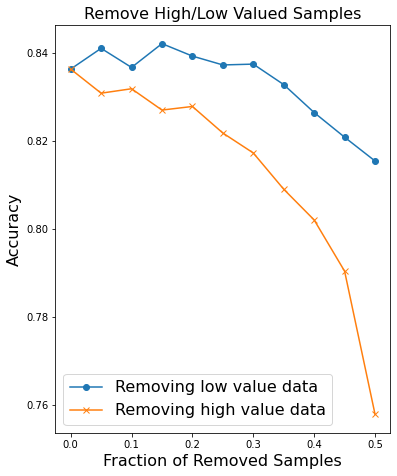

In [ ]:
# Defines evaluation model
eval_model = lightgbm.LGBMClassifier()

# Evaluates performances after removing high/low valued samples
remove_high_low_performance = remove_high_low(dve_out, eval_model, x_train, y_train,
                                              x_valid, y_valid, x_test, y_test, 'accuracy', plot = True)